# Anime Recommendation System

Notebook này xây dựng hệ thống gợi ý anime sử dụng:
- **User-Based Collaborative Filtering**: Dựa trên similarity giữa users
- **Content-Based Filtering**: Dựa trên features của anime (genres, synopsis, metadata)

Dataset được giới hạn 4000 ratings để dễ dàng thực hiện.

## 1. Setup & Data Loading

In [15]:
# Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imported libraries successfully")

✓ Imported libraries successfully


In [16]:
# Download dataset từ Kaggle Hub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hernan4444/anime-recommendation-database-2020")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\hernan4444\anime-recommendation-database-2020\versions\7


In [17]:
# Load datasets
import os

rating_df = pd.read_csv(os.path.join(path, 'animelist.csv'), 
                        usecols=['user_id', 'anime_id', 'rating'])
anime_df = pd.read_csv(os.path.join(path, 'anime.csv'))
anime_synopsis_df = pd.read_csv(os.path.join(path, 'anime_with_synopsis.csv'))

print(f"Rating shape: {rating_df.shape}")
print(f"Anime shape: {anime_df.shape}")
print(f"Synopsis shape: {anime_synopsis_df.shape}")

Rating shape: (109224747, 3)
Anime shape: (17562, 35)
Synopsis shape: (16214, 5)


## 2. Data Preprocessing & Exploration

In [18]:
# Loại bỏ ratings = 0 (người dùng đã xem nhưng không đánh giá)
rating_df = rating_df[rating_df['rating'] > 0]
print(f"After removing 0 ratings: {rating_df.shape}")

# Khám phá dữ liệu
print("\nRating Statistics:")
print(rating_df['rating'].describe())

print("\nNumber of unique users:", rating_df['user_id'].nunique())
print("Number of unique anime:", rating_df['anime_id'].nunique())

After removing 0 ratings: (62397712, 3)

Rating Statistics:
count    6.239771e+07
mean     7.431960e+00
std      1.766560e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

Number of unique users: 313670
Number of unique anime: 17172


In [19]:
# Giới hạn dataset xuống 4000 ratings
# Sample ngẫu nhiên nhưng đảm bảo có đủ users và items
np.random.seed(42)

# Lấy users có nhiều ratings nhất để đảm bảo chất lượng
user_counts = rating_df['user_id'].value_counts()
active_users = user_counts[user_counts >= 5].index[:200]  # Top 200 active users

# Filter ratings từ active users
rating_df_filtered = rating_df[rating_df['user_id'].isin(active_users)]

# Sample 4000 ratings
if len(rating_df_filtered) > 4000:
    rating_df_sampled = rating_df_filtered.sample(n=4000, random_state=42)
else:
    rating_df_sampled = rating_df_filtered

rating_df = rating_df_sampled.copy()
print(f"\nSampled dataset: {rating_df.shape}")
print(f"Unique users: {rating_df['user_id'].nunique()}")
print(f"Unique anime: {rating_df['anime_id'].nunique()}")


Sampled dataset: (4000, 3)
Unique users: 200
Unique anime: 3374


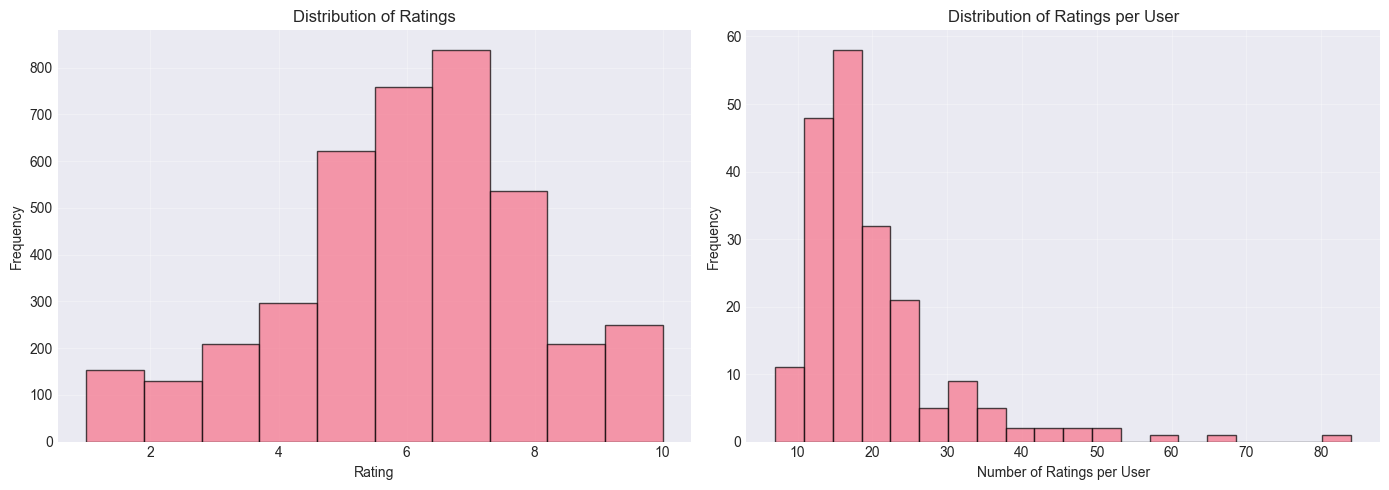

Mean rating: 6.10
Median ratings per user: 17


In [20]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating distribution
axes[0].hist(rating_df['rating'], bins=10, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Ratings')
axes[0].grid(True, alpha=0.3)

# Ratings per user
user_rating_counts = rating_df['user_id'].value_counts()
axes[1].hist(user_rating_counts, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Ratings per User')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Ratings per User')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean rating: {rating_df['rating'].mean():.2f}")
print(f"Median ratings per user: {user_rating_counts.median():.0f}")

## 3. Train/Test Split (Stratified by User)

Để tránh **domain shift**, chúng ta sẽ split dữ liệu theo user:
- Với mỗi user có ít nhất 5 ratings: 80% vào train, 20% vào test
- Users có ít hơn 5 ratings: toàn bộ vào train

Điều này đảm bảo không có "cold start users" trong tập test.

In [21]:
def stratified_split_by_user(df, test_size=0.2, min_ratings=5):
    """
    Split dữ liệu theo user để tránh domain shift.
    
    Args:
        df: DataFrame chứa ratings
        test_size: Tỷ lệ test set (default 0.2)
        min_ratings: Số ratings tối thiểu để user được split (default 5)
    
    Returns:
        train_df, test_df
    """
    train_list = []
    test_list = []
    
    for user_id, group in df.groupby('user_id'):
        n = len(group)
        
        if n >= min_ratings:
            # Shuffle ratings của user này
            group = group.sample(frac=1, random_state=42)
            
            # Split 80/20
            split_idx = int(n * (1 - test_size))
            train_list.append(group.iloc[:split_idx])
            test_list.append(group.iloc[split_idx:])
        else:
            # User có ít ratings -> toàn bộ vào train
            train_list.append(group)
    
    train_df = pd.concat(train_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True)
    
    return train_df, test_df

# Thực hiện split
train_df, test_df = stratified_split_by_user(rating_df, test_size=0.2, min_ratings=5)

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"\nTrain users: {train_df['user_id'].nunique()}")
print(f"Test users: {test_df['user_id'].nunique()}")
print(f"Common users: {len(set(train_df['user_id']) & set(test_df['user_id']))}")
print(f"\nTrain anime: {train_df['anime_id'].nunique()}")
print(f"Test anime: {test_df['anime_id'].nunique()}")

Train set: (3117, 3)
Test set: (883, 3)

Train users: 200
Test users: 200
Common users: 200

Train anime: 2734
Test anime: 845


## 4. User-Based Collaborative Filtering

Mô hình này dựa trên giả định: **Users tương tự nhau sẽ có sở thích tương tự**

### Steps:
1. Tạo user-item rating matrix
2. Tính user-user cosine similarity
3. Dự đoán rating dựa trên weighted average của similar users

In [22]:
# Tạo user-item matrix từ train set
train_matrix = train_df.pivot_table(index='user_id', 
                                     columns='anime_id', 
                                     values='rating',
                                     fill_value=0)

print(f"User-item matrix shape: {train_matrix.shape}")
print(f"Sparsity: {(train_matrix == 0).sum().sum() / (train_matrix.shape[0] * train_matrix.shape[1]) * 100:.2f}%")

User-item matrix shape: (200, 2734)
Sparsity: 99.43%


In [23]:
# Tính user-user cosine similarity
# Chỉ tính trên các anime đã được rate (ignore zeros)
from sklearn.metrics.pairwise import cosine_similarity

# Convert to sparse matrix for efficiency
train_sparse = csr_matrix(train_matrix.values)

# Tính cosine similarity
user_similarity = cosine_similarity(train_sparse, dense_output=True)
user_similarity_df = pd.DataFrame(user_similarity, 
                                   index=train_matrix.index,
                                   columns=train_matrix.index)

print(f"User similarity matrix shape: {user_similarity_df.shape}")
print(f"\nSample similarity scores:")
print(user_similarity_df.iloc[:5, :5])

User similarity matrix shape: (200, 200)

Sample similarity scores:
user_id  781   890   4773  5648  7179
user_id                              
781       1.0   0.0   0.0   0.0   0.0
890       0.0   1.0   0.0   0.0   0.0
4773      0.0   0.0   1.0   0.0   0.0
5648      0.0   0.0   0.0   1.0   0.0
7179      0.0   0.0   0.0   0.0   1.0


In [24]:
def predict_user_based(user_id, anime_id, train_matrix, user_similarity_df, k=20):
    """
    Dự đoán rating của user cho anime dựa trên collaborative filtering.
    
    Args:
        user_id: ID của user
        anime_id: ID của anime
        train_matrix: User-item rating matrix
        user_similarity_df: User-user similarity matrix
        k: Số lượng similar users để xem xét
    
    Returns:
        Predicted rating (1-10)
    """
    # Kiểm tra user và anime có trong train set không
    if user_id not in train_matrix.index:
        return train_df['rating'].mean()  # Return global mean
    
    if anime_id not in train_matrix.columns:
        # Return user's mean rating
        user_ratings = train_matrix.loc[user_id]
        user_mean = user_ratings[user_ratings > 0].mean()
        return user_mean if not np.isnan(user_mean) else train_df['rating'].mean()
    
    # Lấy similarity scores của user này với các users khác
    similarities = user_similarity_df[user_id]
    
    # Lấy ratings của anime này từ tất cả users
    anime_ratings = train_matrix[anime_id]
    
    # Chỉ xét users đã rate anime này (rating > 0)
    rated_users = anime_ratings[anime_ratings > 0].index
    
    if len(rated_users) == 0:
        # Không có user nào rate anime này
        user_ratings = train_matrix.loc[user_id]
        user_mean = user_ratings[user_ratings > 0].mean()
        return user_mean if not np.isnan(user_mean) else train_df['rating'].mean()
    
    # Lấy top-k similar users đã rate anime này
    similar_users = similarities.loc[rated_users].sort_values(ascending=False)[:k]
    
    if len(similar_users) == 0 or similar_users.sum() == 0:
        user_ratings = train_matrix.loc[user_id]
        user_mean = user_ratings[user_ratings > 0].mean()
        return user_mean if not np.isnan(user_mean) else train_df['rating'].mean()
    
    # Weighted average của ratings
    weighted_sum = 0
    similarity_sum = 0
    
    for similar_user, similarity in similar_users.items():
        if similar_user == user_id:
            continue  # Skip chính user đó
        rating = anime_ratings[similar_user]
        weighted_sum += similarity * rating
        similarity_sum += similarity
    
    if similarity_sum == 0:
        user_ratings = train_matrix.loc[user_id]
        user_mean = user_ratings[user_ratings > 0].mean()
        return user_mean if not np.isnan(user_mean) else train_df['rating'].mean()
    
    predicted_rating = weighted_sum / similarity_sum
    
    # Clip rating trong khoảng [1, 10]
    return np.clip(predicted_rating, 1, 10)

# Test function
sample_user = train_df['user_id'].iloc[0]
sample_anime = train_df['anime_id'].iloc[0]
pred = predict_user_based(sample_user, sample_anime, train_matrix, user_similarity_df)
print(f"Sample prediction: User {sample_user}, Anime {sample_anime} -> Rating {pred:.2f}")

Sample prediction: User 781, Anime 35394 -> Rating 5.67


In [25]:
# Evaluate User-Based CF trên test set
print("Đang dự đoán ratings cho test set...")

predictions = []
actuals = []

for idx, row in test_df.iterrows():
    pred = predict_user_based(row['user_id'], row['anime_id'], 
                              train_matrix, user_similarity_df, k=20)
    predictions.append(pred)
    actuals.append(row['rating'])
    
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(test_df)} predictions")

# Tính metrics
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print("\n" + "="*50)
print("USER-BASED COLLABORATIVE FILTERING RESULTS")
print("="*50)
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print("="*50)

Đang dự đoán ratings cho test set...
Processed 100/883 predictions
Processed 200/883 predictions
Processed 300/883 predictions
Processed 400/883 predictions
Processed 500/883 predictions
Processed 600/883 predictions
Processed 700/883 predictions
Processed 800/883 predictions

USER-BASED COLLABORATIVE FILTERING RESULTS
RMSE: 1.6616
MAE:  1.2677


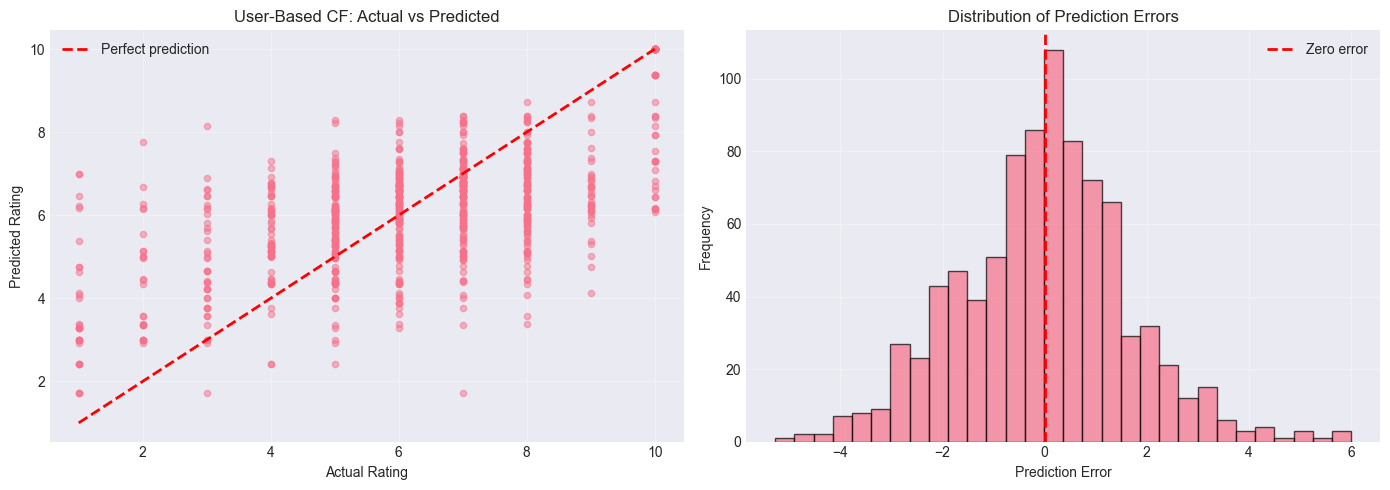

Mean error: -0.0283
Std error: 1.6613


In [26]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(actuals, predictions, alpha=0.5, s=20)
axes[0].plot([1, 10], [1, 10], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title('User-Based CF: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = np.array(predictions) - np.array(actuals)
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero error')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Errors')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean error: {errors.mean():.4f}")
print(f"Std error: {errors.std():.4f}")

## 5. Content-Based Filtering

Mô hình này dựa trên giả định: **Anime tương tự nhau về nội dung sẽ được user thích tương tự**

### Features:
1. **Metadata**: Genres, Producers, Studios, Source
2. **Synopsis**: Tóm tắt nội dung (TF-IDF)

In [27]:
# Chuẩn bị anime features
# Chỉ lấy các anime có trong train set
train_anime_ids = train_df['anime_id'].unique()

anime_features = anime_df[anime_df['MAL_ID'].isin(train_anime_ids)].copy()
anime_features = anime_features.sort_values(by='MAL_ID').reset_index(drop=True)

print(f"Number of anime in train set: {len(anime_features)}")
anime_features[['MAL_ID', 'Name', 'Genres', 'Producers', 'Studios']].head()

Number of anime in train set: 2734


,MAL_ID,Name,Genres,Producers,Studios
0,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Victor Entertainment,Madhouse
1,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...","VAP, Shogakukan-Shueisha Productions, Nippon T...",Madhouse
2,22,Tennis no Ouji-sama,"Action, Comedy, Sports, School, Shounen","Production I.G, Nihon Ad Systems",Trans Arts
3,23,Ring ni Kakero 1,"Action, Shounen, Sports",Unknown,Toei Animation
4,25,Sunabouzu,"Action, Adventure, Comedy, Ecchi, Sci-Fi, Shounen","GDH, Pony Canyon, CBC",Gonzo


In [28]:
# Merge với synopsis
anime_features = anime_features.merge(
    anime_synopsis_df[['MAL_ID', 'sypnopsis']], 
    on='MAL_ID', 
    how='left'
)

# Fill missing values
anime_features = anime_features.fillna('')

print(f"Anime with synopsis: {(anime_features['sypnopsis'] != '').sum()}")

Anime with synopsis: 2561


In [29]:
# Xử lý metadata features
def clean_data(x):
    """Clean và normalize text data."""
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    elif isinstance(x, str):
        return str.lower(x.replace(" ", ""))
    else:
        return ''

# Split comma-separated values
metadata_features = ['Genres', 'Producers', 'Studios']
for feature in metadata_features:
    anime_features[feature] = anime_features[feature].apply(
        lambda x: x.split(',') if isinstance(x, str) else []
    )

# Clean all features
all_features = metadata_features + ['Source']
for feature in all_features:
    anime_features[feature] = anime_features[feature].apply(clean_data)

# Tạo "soup" - kết hợp tất cả metadata
def create_soup(x):
    """Kết hợp tất cả metadata thành một string."""
    genres = ' '.join(x['Genres']) if isinstance(x['Genres'], list) else ''
    producers = ' '.join(x['Producers']) if isinstance(x['Producers'], list) else ''
    studios = ' '.join(x['Studios']) if isinstance(x['Studios'], list) else ''
    source = x['Source'] if isinstance(x['Source'], str) else ''
    return f"{genres} {producers} {studios} {source}"

anime_features['metadata_soup'] = anime_features.apply(create_soup, axis=1)

print("Sample metadata soup:")
print(anime_features[['Name', 'metadata_soup']].head())

Sample metadata soup:
                  Name                                      metadata_soup
0               Trigun  action sci-fi adventure comedy drama shounen v...
1              Monster  drama horror mystery police psychological sein...
2  Tennis no Ouji-sama  action comedy sports school shounen production...
3     Ring ni Kakero 1  action shounen sports unknown toeianimation manga
4            Sunabouzu  action adventure comedy ecchi sci-fi shounen g...


In [30]:
# Tạo feature vectors
# 1. Metadata features (CountVectorizer)
count_vectorizer = CountVectorizer(stop_words='english')
metadata_matrix = count_vectorizer.fit_transform(anime_features['metadata_soup'])

print(f"Metadata matrix shape: {metadata_matrix.shape}")

# 2. Synopsis features (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
synopsis_matrix = tfidf_vectorizer.fit_transform(anime_features['sypnopsis'])

print(f"Synopsis matrix shape: {synopsis_matrix.shape}")

Metadata matrix shape: (2734, 939)
Synopsis matrix shape: (2734, 500)


In [31]:
# Tính item-item similarity
# Normalize trước khi tính cosine
from sklearn.preprocessing import normalize

metadata_normalized = normalize(metadata_matrix, norm='l2')
synopsis_normalized = normalize(synopsis_matrix, norm='l2')

# Tính cosine similarity cho mỗi feature type
metadata_similarity = metadata_normalized @ metadata_normalized.T
synopsis_similarity = synopsis_normalized @ synopsis_normalized.T

# Kết hợp (trung bình có trọng số)
# Metadata có trọng số cao hơn vì reliable hơn
content_similarity = 0.6 * metadata_similarity + 0.4 * synopsis_similarity

# Convert to dense array
content_similarity = content_similarity.toarray()

# Tạo DataFrame với index là anime_id
content_similarity_df = pd.DataFrame(
    content_similarity,
    index=anime_features['MAL_ID'],
    columns=anime_features['MAL_ID']
)

print(f"Content similarity matrix shape: {content_similarity_df.shape}")
print("\nSample similarity scores:")
print(content_similarity_df.iloc[:5, :5])

Content similarity matrix shape: (2734, 2734)

Sample similarity scores:
MAL_ID        6         19        22        23        25
MAL_ID                                                  
6       1.000000  0.257954  0.274000  0.279407  0.431875
19      0.257954  1.000000  0.107132  0.087177  0.055825
22      0.274000  0.107132  1.000000  0.393254  0.262916
23      0.279407  0.087177  0.393254  1.000000  0.212132
25      0.431875  0.055825  0.262916  0.212132  1.000000


In [32]:
def get_content_based_recommendations(user_id, train_df, content_similarity_df, k=10):
    """
    Recommend anime dựa trên content similarity.
    
    Args:
        user_id: ID của user
        train_df: Training data
        content_similarity_df: Item-item similarity matrix
        k: Số lượng recommendations
    
    Returns:
        List of (anime_id, score) tuples
    """
    # Lấy các anime mà user đã rated
    user_ratings = train_df[train_df['user_id'] == user_id]
    
    if len(user_ratings) == 0:
        return []  # Cold start user
    
    # Lấy các anime user đã xem
    watched_anime = set(user_ratings['anime_id'])
    
    # Tính score cho mỗi anime chưa xem
    scores = {}
    
    for anime_id in content_similarity_df.columns:
        if anime_id in watched_anime:
            continue  # Skip anime đã xem
        
        # Tính weighted score dựa trên similarity với các anime đã rated
        weighted_score = 0
        total_weight = 0
        
        for _, rated_row in user_ratings.iterrows():
            rated_anime_id = rated_row['anime_id']
            rating = rated_row['rating']
            
            if rated_anime_id in content_similarity_df.index:
                similarity = content_similarity_df.loc[rated_anime_id, anime_id]
                weighted_score += similarity * rating
                total_weight += similarity
        
        if total_weight > 0:
            scores[anime_id] = weighted_score / total_weight
    
    # Sort và lấy top-k
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores[:k]

# Test function
sample_user = train_df['user_id'].iloc[0]
recommendations = get_content_based_recommendations(sample_user, train_df, content_similarity_df, k=5)

print(f"Top 5 recommendations for user {sample_user}:")
for anime_id, score in recommendations:
    anime_name = anime_df[anime_df['MAL_ID'] == anime_id]['Name'].values
    anime_name = anime_name[0] if len(anime_name) > 0 else 'Unknown'
    print(f"  {anime_name} (ID: {anime_id}, Score: {score:.3f})")

Top 5 recommendations for user 781:
  Love Live! Sunshine!! 2nd Season (ID: 34973, Score: 8.356)
  Ginga e Kickoff!! (ID: 12875, Score: 8.255)
  Amagami SS: Tachibana Miya-hen - Imouto (ID: 9925, Score: 8.202)
  Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen (ID: 6351, Score: 8.154)
  Clannad: Mou Hitotsu no Sekai, Tomoyo-hen (ID: 4059, Score: 8.115)


In [33]:
def predict_content_based(user_id, anime_id, train_df, content_similarity_df):
    """
    Dự đoán rating của user cho anime dựa trên content similarity.
    
    Args:
        user_id: ID của user
        anime_id: ID của anime
        train_df: Training data
        content_similarity_df: Item-item similarity matrix
    
    Returns:
        Predicted rating (1-10)
    """
    # Lấy các anime mà user đã rated
    user_ratings = train_df[train_df['user_id'] == user_id]
    
    if len(user_ratings) == 0:
        return train_df['rating'].mean()  # Cold start
    
    if anime_id not in content_similarity_df.columns:
        # Anime không có trong similarity matrix
        return user_ratings['rating'].mean()
    
    # Tính weighted rating
    weighted_sum = 0
    similarity_sum = 0
    
    for _, row in user_ratings.iterrows():
        rated_anime_id = row['anime_id']
        rating = row['rating']
        
        if rated_anime_id in content_similarity_df.index:
            similarity = content_similarity_df.loc[rated_anime_id, anime_id]
            weighted_sum += similarity * rating
            similarity_sum += abs(similarity)
    
    if similarity_sum == 0:
        return user_ratings['rating'].mean()
    
    predicted_rating = weighted_sum / similarity_sum
    return np.clip(predicted_rating, 1, 10)

# Test
sample_pred = predict_content_based(sample_user, train_df['anime_id'].iloc[10], 
                                    train_df, content_similarity_df)
print(f"Sample prediction: {sample_pred:.2f}")

Sample prediction: 6.40


In [34]:
# Evaluate Content-Based Filtering trên test set
print("Đang dự đoán ratings cho test set (Content-Based)...")

cb_predictions = []
cb_actuals = []

for idx, row in test_df.iterrows():
    pred = predict_content_based(row['user_id'], row['anime_id'], 
                                 train_df, content_similarity_df)
    cb_predictions.append(pred)
    cb_actuals.append(row['rating'])
    
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(test_df)} predictions")

# Tính metrics
cb_rmse = np.sqrt(mean_squared_error(cb_actuals, cb_predictions))
cb_mae = mean_absolute_error(cb_actuals, cb_predictions)

print("\n" + "="*50)
print("CONTENT-BASED FILTERING RESULTS")
print("="*50)
print(f"RMSE: {cb_rmse:.4f}")
print(f"MAE:  {cb_mae:.4f}")
print("="*50)

Đang dự đoán ratings cho test set (Content-Based)...
Processed 100/883 predictions
Processed 200/883 predictions
Processed 300/883 predictions
Processed 400/883 predictions
Processed 500/883 predictions
Processed 600/883 predictions
Processed 700/883 predictions
Processed 800/883 predictions

CONTENT-BASED FILTERING RESULTS
RMSE: 1.6373
MAE:  1.2470


## 6. Model Comparison & Analysis


                    MODEL COMPARISON
        Model     RMSE      MAE
User-Based CF 1.661551 1.267734
Content-Based 1.637318 1.247000


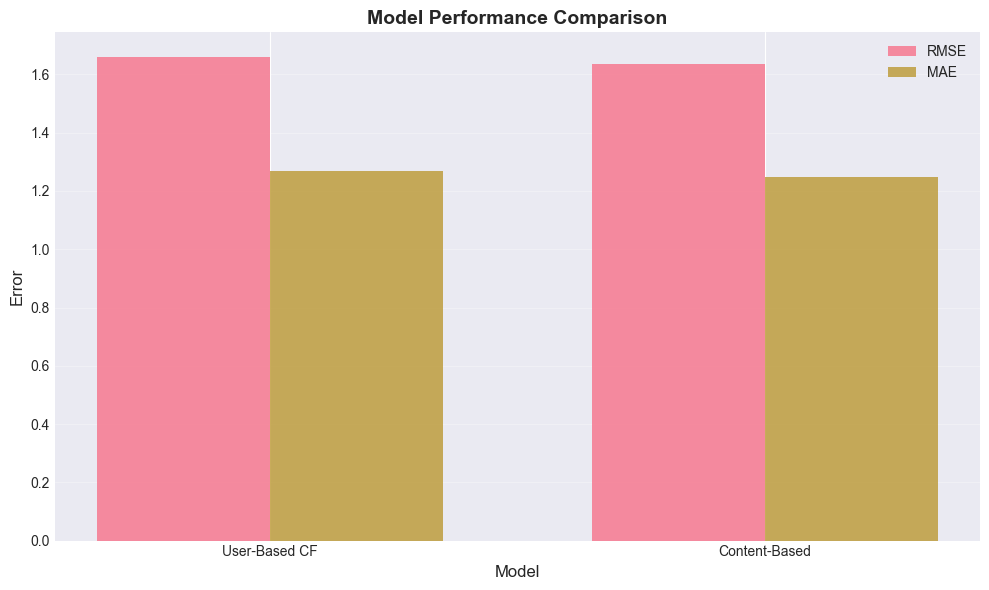


🏆 Best Model (lowest RMSE): Content-Based


In [35]:
# So sánh hai mô hình
comparison_df = pd.DataFrame({
    'Model': ['User-Based CF', 'Content-Based'],
    'RMSE': [rmse, cb_rmse],
    'MAE': [mae, cb_mae]
})

print("\n" + "="*60)
print(" "*20 + "MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df['Model']))
width = 0.35

ax.bar(x - width/2, comparison_df['RMSE'], width, label='RMSE', alpha=0.8)
ax.bar(x + width/2, comparison_df['MAE'], width, label='MAE', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Determine best model
best_model = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
print(f"\n🏆 Best Model (lowest RMSE): {best_model}")

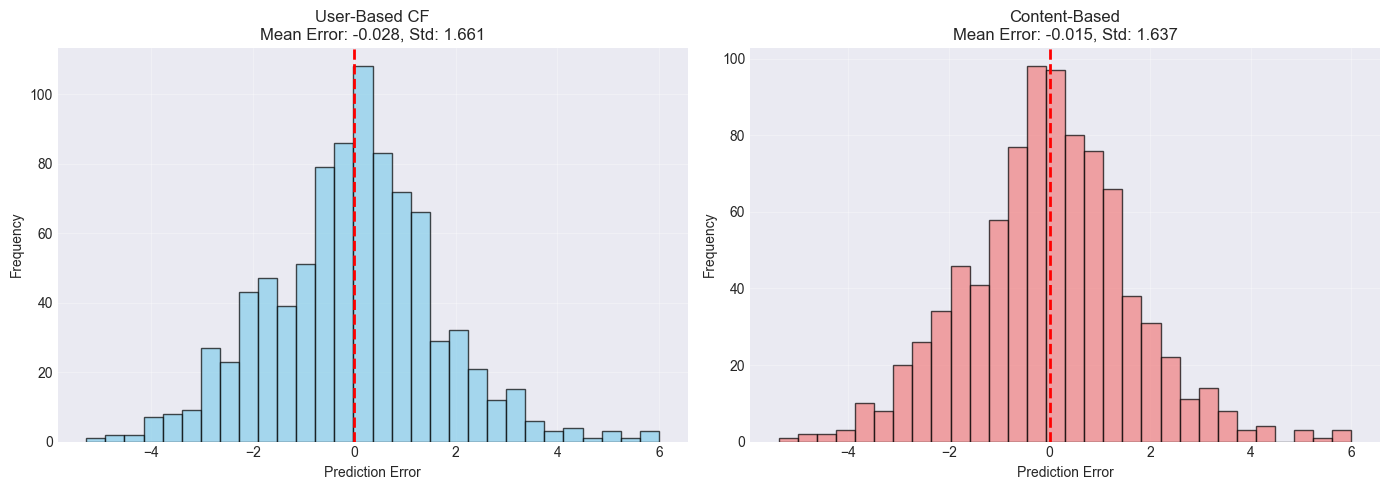

In [36]:
# Phân tích sâu hơn - Error distribution comparison
ub_errors = np.array(predictions) - np.array(actuals)
cb_errors = np.array(cb_predictions) - np.array(cb_actuals)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User-Based CF errors
axes[0].hist(ub_errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'User-Based CF\nMean Error: {ub_errors.mean():.3f}, Std: {ub_errors.std():.3f}')
axes[0].grid(True, alpha=0.3)

# Content-Based errors
axes[1].hist(cb_errors, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Content-Based\nMean Error: {cb_errors.mean():.3f}, Std: {cb_errors.std():.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Case Study: Example Recommendations

In [37]:
# Chọn một user để demo
demo_user = train_df['user_id'].value_counts().index[0]  # User có nhiều ratings nhất

print(f"Demo User ID: {demo_user}")
print("="*70)

# Xem anime mà user đã rated
user_history = train_df[train_df['user_id'] == demo_user].merge(
    anime_df[['MAL_ID', 'Name', 'Genres']], 
    left_on='anime_id', 
    right_on='MAL_ID'
).sort_values('rating', ascending=False)

print("\nUser's Top Rated Anime:")
print(user_history[['Name', 'Genres', 'rating']].head(10).to_string(index=False))

Demo User ID: 189037

User's Top Rated Anime:
                                                   Name                                                  Genres  rating
                                      Kyoukai no Kanata                    Slice of Life, Supernatural, Fantasy       8
                                                 Wonder                                            Music, Space       7
            Souta no Chikai: Sabetsu ni Makenai Chikara                                 Drama, Historical, Kids       7
                                         Kemeko Deluxe! Action, Comedy, Ecchi, Romance, School, Sci-Fi, Shounen       7
8-shaku 8-wa Kerakumeguri: Igyou Kaikitan The Animation                                    Hentai, Supernatural       7
                        K: Missing Kings - Manner Movie                                                  Comedy       7
                                        Rokka no Yuusha              Action, Adventure, Fantasy, Magic, Mystery   

In [38]:
# Get recommendations từ Content-Based model
recommendations = get_content_based_recommendations(
    demo_user, train_df, content_similarity_df, k=10
)

print("\n" + "="*70)
print("TOP 10 RECOMMENDATIONS (Content-Based):")
print("="*70)

for i, (anime_id, score) in enumerate(recommendations, 1):
    anime_info = anime_df[anime_df['MAL_ID'] == anime_id]
    if len(anime_info) > 0:
        name = anime_info['Name'].values[0]
        genres = anime_info['Genres'].values[0]
        print(f"{i}. {name}")
        print(f"   Genres: {genres}")
        print(f"   Score: {score:.3f}")
        print()


TOP 10 RECOMMENDATIONS (Content-Based):
1. Kamisama no Memochou
   Genres: Mystery
   Score: 7.137

2. Kabuki-bu!
   Genres: School
   Score: 7.115

3. Rail Wars!
   Genres: Action, Harem, Police, Ecchi
   Score: 7.111

4. Tsurune: Kazemai Koukou Kyuudoubu
   Genres: Sports, Drama, School
   Score: 7.103

5. Kengan Ashura 2nd Season
   Genres: Action, Martial Arts
   Score: 7.101

6. Yakushiji Ryouko no Kaiki Jikenbo: Hamachou, Voice & Fiction
   Genres: Police, Supernatural, Mystery
   Score: 7.098

7. Another
   Genres: Mystery, Horror, Supernatural, Thriller, School
   Score: 7.097

8. Aura: Maryuuin Kouga Saigo no Tatakai
   Genres: Supernatural, Drama, Romance, School
   Score: 7.092

9. "Bungaku Shoujo" Memoire
   Genres: Drama, Romance, School
   Score: 7.079

10. Higurashi no Naku Koro ni Special: Nekogoroshi-hen
   Genres: Mystery
   Score: 7.078



## 8. Conclusions

### Tổng kết kết quả:

1. **User-Based Collaborative Filtering**:
   - **Ưu điểm**: 
     - Có thể tìm ra anime mà người dùng tương tự thích
     - Không cần thông tin về nội dung anime
   - **Nhược điểm**:
     - Cold start problem: Khó dự đoán cho users mới
     - Sparsity: Matrix rating thường rất sparse
     - Scalability: Tính toán tốn kém khi số users lớn

2. **Content-Based Filtering**:
   - **Ưu điểm**:
     - Giải quyết được cold start problem cho items mới
     - Có thể giải thích được recommendations (dựa trên features)
   - **Nhược điểm**:
     - Giới hạn trong việc khám phá anime mới (limited serendipity)
     - Phụ thuộc vào chất lượng features
     - Không học được từ community

### Hướng phát triển:
- **Hybrid Model**: Kết hợp cả hai approaches để tận dụng ưu điểm của mỗi bên
- **Matrix Factorization**: SVD, ALS để xử lý sparsity tốt hơn
- **Deep Learning**: Neural Collaborative Filtering, Autoencoders
- **Context-Aware**: Thêm thông tin về thời gian, mood, device,...
- **Explainability**: Giải thích rõ hơn tại sao recommend một anime

### Notes về Train/Test Split:
- Đã sử dụng **stratified split by user** để tránh domain shift
- Đảm bảo tất cả users trong test set đều có trong train set
- Điều này giúp đánh giá model một cách fair và realistic hơn